# exploring whether fitting 2 - 24 Hz is best for our situation

In Voytek et al. 2015, spectral slope is found by robustly fitting between 2 and 24 Hz and excluding 7 Hz - 14 Hz, or the presumed alpha peak. Would we achieve better results if we include more, or less frequencies?

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import signal
from scipy import io
from sklearn import metrics, cross_validation
from sklearn import linear_model

First, let's see at how we're currently fitting to slopes. What do the fitted lines look like?

In [13]:
subjoa = {} # Dictionary that holds subject data
srate = 512

matfiles = []
for root, dirs, files in os.walk('../data/pipeline-20s-eyesc/oaExclFiltCARClust-mat/'):
    matfiles += glob.glob(os.path.join(root, '*.mat'))

# Import all subjects
for i in range(len(matfiles)):
    datafile = sp.io.loadmat(matfiles[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))[6:]
    subjoa[i]['data'] = np.squeeze(datafile['data'])

In [14]:
def compute_slope_ransac(f, psd):
    """ 
    Robustly fits line to PSD. Returns slope and fit line. 
    Note that we fit to the PSD in semi-log space. Also, fitting
    is only done from 2 - 24 Hz, as in Voytek et al. 2015
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0][0] * (10**2), fit_line

In [30]:
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd ** 2
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjoa[i][ch]['slope'], subjoa[i][ch]['fit_line'] = compute_slope_ransac(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'])
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjoa[i]['data'])):
        slopes.append(subjoa[i][ch]['slope'])
    subjoa[i]['avg_psd_slope'] = np.mean(slopes)

(0, 60)

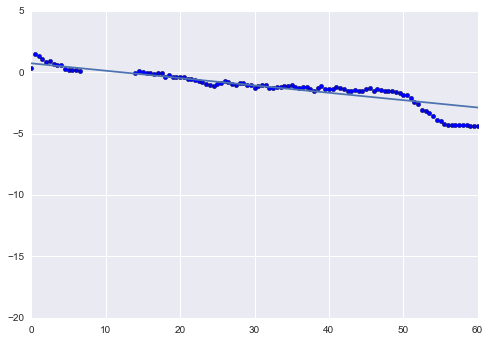

In [31]:
plt.scatter(subjoa[0][0]['f_sans_alpha'], np.log10(subjoa[0][0]['psd_sans_alpha']))
plt.plot(subjoa[0][0]['f_sans_alpha'], subjoa[0][0]['fit_line'])
plt.xlim([0, 60])

(0, 60)

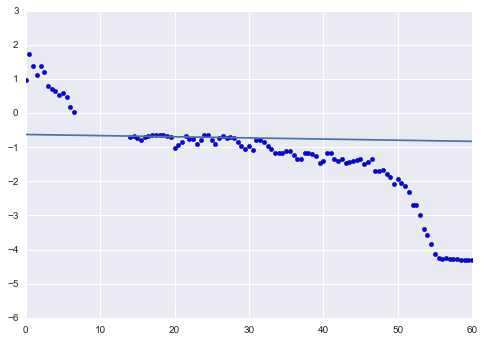

In [32]:
plt.scatter(subjoa[30][0]['f_sans_alpha'], np.log10(subjoa[30][0]['psd_sans_alpha']))
plt.plot(subjoa[30][0]['f_sans_alpha'], subjoa[30][0]['fit_line'])
plt.xlim([0, 60])

(0, 60)

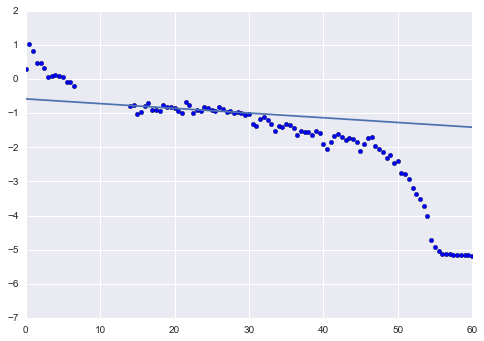

In [18]:
plt.scatter(subjoa[30][57]['f_sans_alpha'], np.log10(subjoa[30][57]['psd_sans_alpha']))
plt.plot(subjoa[30][57]['f_sans_alpha'], subjoa[30][57]['fit_line'])
plt.xlim([0, 60])

Okay, that might be problematic. I've prepped a group of files that were bandpass-filtered from 0 - 150 Hz -- this would likely let us more clearly see the neural noise. Let's see what they look like:

In [19]:
subjoa = {} # Dictionary that holds subject data
srate = 512

matfiles = []
for root, dirs, files in os.walk('../data/examine-slope-fit/'):
    matfiles += glob.glob(os.path.join(root, '*.mat'))

# Import all subjects
for i in range(len(matfiles)):
    datafile = sp.io.loadmat(matfiles[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))[6:]
    subjoa[i]['data'] = np.squeeze(datafile['data'])

In [20]:
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line
        subjoa[i][ch]['slope'], subjoa[i][ch]['fit_line'] = compute_slope_ransac(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'])
    # Compute average slope for this subject
    slopes = []
    for ch in range(len(subjoa[i]['data'])):
        slopes.append(subjoa[i][ch]['slope'])
    subjoa[i]['avg_psd_slope'] = np.mean(slopes)

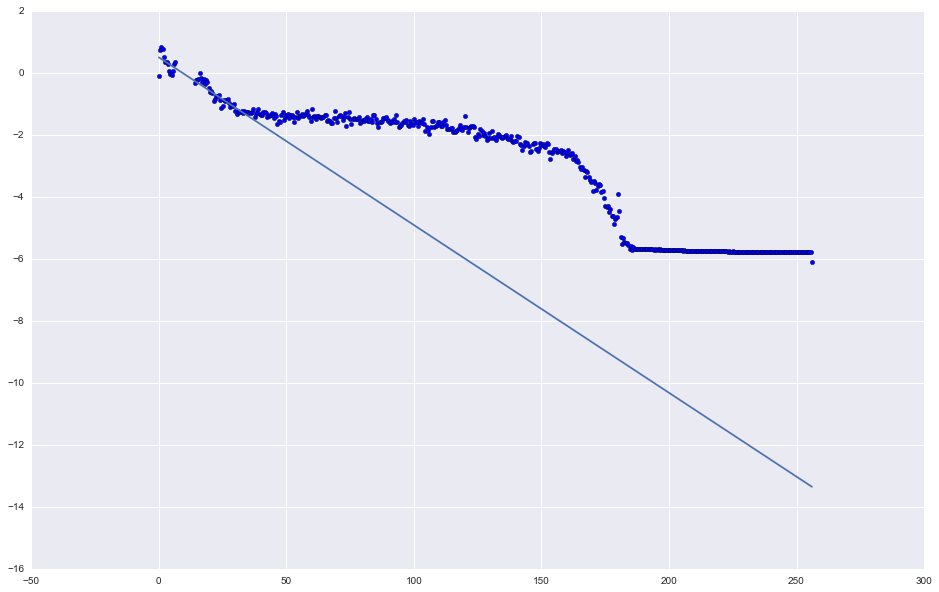

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(subjoa[1][57]['f_sans_alpha'], np.log10(subjoa[1][57]['psd_sans_alpha']))
plt.plot(subjoa[1][57]['f_sans_alpha'], subjoa[1][57]['fit_line'])
# plt.xlim([0, 90])

The slope would not have been this steep if we hadn't fit in the 2 - 24 Hz range. This is probably good. Okay, what if instead, in order to avoid the situation we saw earlier, of getting a really flat slope (and ignoring the delta/theta values), we use a more lax regression algorithm?

## regular linear regression

First, let's look at the subjects that we saw at the very beginning of the notebook:

In [22]:
subjoa = {} # Dictionary that holds subject data
srate = 512

matfiles = []
for root, dirs, files in os.walk('../data/pipeline-20s-eyesc/oaExclFiltCARClust-mat/'):
    matfiles += glob.glob(os.path.join(root, '*.mat'))

# Import all subjects
for i in range(len(matfiles)):
    datafile = sp.io.loadmat(matfiles[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))[6:]
    subjoa[i]['data'] = np.squeeze(datafile['data'])

We'll be fitting using regular regression, not the robust kind.

In [24]:
def compute_slope(f, psd):
    """ 
    Robustly fits line to PSD. Returns slope and fit line. 
    Note that we fit to the PSD in semi-log space. Also, fitting
    is only done from 2 - 24 Hz, as in Voytek et al. 2015
    """
    model = linear_model.LinearRegression()
    model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    return model.predict(f)

In [25]:
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd ** 2
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line subjoa[i][ch]['slope'], 
        subjoa[i][ch]['fit_line'] = compute_slope(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'])
    # Compute average slope for this subject
#     slopes = []
#     for ch in range(len(subjoa[i]['data'])):
#         slopes.append(subjoa[i][ch]['slope'])
#     subjoa[i]['avg_psd_slope'] = np.mean(slopes)

(0, 60)

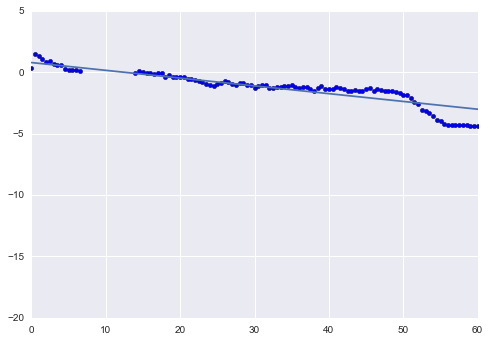

In [26]:
plt.scatter(subjoa[0][0]['f_sans_alpha'], np.log10(subjoa[0][0]['psd_sans_alpha']))
plt.plot(subjoa[0][0]['f_sans_alpha'], subjoa[0][0]['fit_line'])
plt.xlim([0, 60])

In [55]:
f = subjoa[30][0]['f_sans_alpha']
psd = subjoa[30][0]['psd_sans_alpha']
model = linear_model.LinearRegression()
model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))

plt.figure(figsize=(16,10))
plt.scatter(subjoa[30][0]['f_sans_alpha'], np.log10(subjoa[30][0]['psd_sans_alpha']))
plt.plot(subjoa[30][0]['f_sans_alpha'], subjoa[30][0]['fit_line'])
plt.plot(f, model.predict(f))
plt.xlim([0, 60])

KeyError: 30

(0, 60)

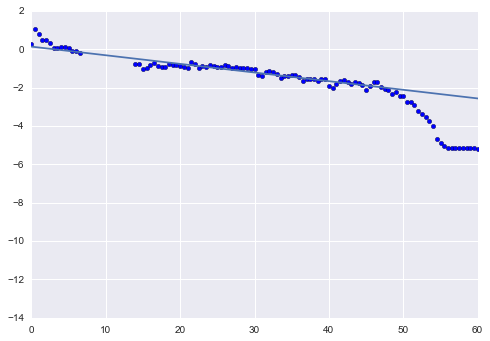

In [28]:
plt.scatter(subjoa[30][57]['f_sans_alpha'], np.log10(subjoa[30][57]['psd_sans_alpha']))
plt.plot(subjoa[30][57]['f_sans_alpha'], subjoa[30][57]['fit_line'])
plt.xlim([0, 60])

# what if we fit to higher ranges?

Voytek chose to fit to lower frequencies (2 - 24 Hz) because he reasons that slope changes should be evident, even at lower frequencies. Let's try fitting to higher frequencies. What does the PSD look like up there, across subjects?

Let's prepare a few subjects but skip the bandpass-filter. Running the following:

```
_psd-slope/data/examine-slope-no-filt/

mkdir oa-set

cl_importcnt('_data', 'oa-set');
cl_montage('oa-set', 'oa-set', 'extClinicalCh');
cl_rereference('oa-set','oa-set','CAR');
cl_clusters('oa-set','oa-set','10-20-dense');
set_mat_converter('oa-set', pwd);
```

In [38]:
subjoa = {} # Dictionary that holds subject data
srate = 512

matfiles = []
for root, dirs, files in os.walk('../data/examine-slope-fit-no-filt/'):
    matfiles += glob.glob(os.path.join(root, '*.mat'))

# Import all subjects
for i in range(len(matfiles)):
    datafile = sp.io.loadmat(matfiles[i])
    subjoa[i] = {}
    subjoa[i]['name'] = str(np.squeeze(datafile['name']))[6:]
    subjoa[i]['data'] = np.squeeze(datafile['data'])

In [39]:
for i in subjoa:
    for ch in range(len(subjoa[i]['data'])):

        subjoa[i][ch] = {}
        
        f, psd = sp.signal.welch(subjoa[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
        f   = f.reshape((len(f), 1))
        psd = psd.reshape((len(psd), 1))
        
        subjoa[i][ch]['f'] = f
        subjoa[i][ch]['psd'] = psd ** 2
        
        # Remove alpha peak from the power spectrum:        
        subjoa[i][ch]['psd_sans_alpha'] = np.delete(psd, range(7*2, 14*2))
        subjoa[i][ch]['f_sans_alpha']   = np.delete(f, range(7*2, 14*2))
        subjoa[i][ch]['psd_sans_alpha'] = subjoa[i][ch]['psd_sans_alpha'].reshape((len(subjoa[i][ch]['psd_sans_alpha']), 1))
        subjoa[i][ch]['f_sans_alpha']   = subjoa[i][ch]['f_sans_alpha'].reshape((len(subjoa[i][ch]['f_sans_alpha']), 1))
        
        # Compute slope of this channel, and store fit line subjoa[i][ch]['slope'], 
        subjoa[i][ch]['fit_line'] = compute_slope(subjoa[i][ch]['f_sans_alpha'], 
                                                                          subjoa[i][ch]['psd_sans_alpha'])
    # Compute average slope for this subject
#     slopes = []
#     for ch in range(len(subjoa[i]['data'])):
#         slopes.append(subjoa[i][ch]['slope'])
#     subjoa[i]['avg_psd_slope'] = np.mean(slopes)

134


(0, 100)

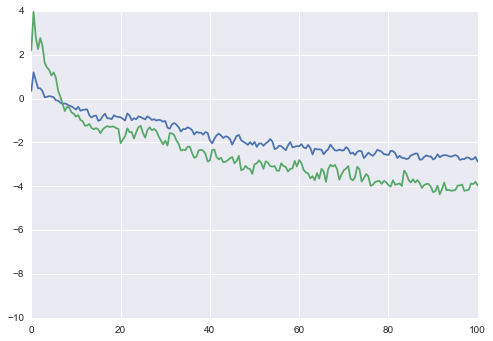

In [54]:
print(subjoa[len(subjoa)-1]['name'])

plt.plot(f, np.log10(psd))
plt.plot(subjoa[len(subjoa)-1][0]['f'], np.log10(subjoa[len(subjoa)-1][0]['psd']))
plt.xlim([0, 100])

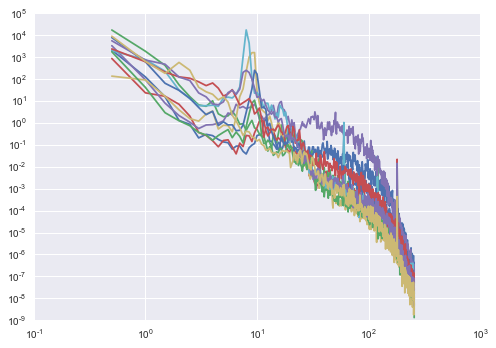

In [47]:
for i in subjoa:
    plt.loglog(subjoa[i][0]['f'], subjoa[i][0]['psd'])